In [22]:


from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')



<img src='Header.png' style="width:100%">

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from IPython.display import display, Markdown, Latex
import warnings
warnings.filterwarnings("ignore")

# I. Introduction

Building on what our awesome classmates' findings, we used other machine learning models to determine the presence of heart diseases.

While our classmates used a k-Nearest Neighbors Classifier as their machine learning model, we now used Logistic Regression and Support Vector Machine with a linear kernel to predict the presence of heart diseases using the same dataset that they used.

#### Disclaimer: The findings presented are only based on the dataset used and should not be taken as general truths.

# II. Function Definitions

In [20]:
def logistic_regression(features, target, train_range=50, test_size=0.3, 
                        max_iter=1000, solver='lbfgs', class_weight=None,
                        penalty='l2', C=[1e-3,0.1, 0.2,0.4, 0.75, 
                                         1, 1.5, 3, 5, 10, 15,  20, 
                                         100, 300, 1000, 5000],
                        scaler=None):

    tmpdf = pd.DataFrame(columns=['i','C','type','value']) 
    coefs = []
    
    for i in range(1, train_range, 1):
        X_train, X_test,\
        y_train, y_test = train_test_split(features, target, 
                                           test_size=test_size, 
                                           random_state=i, 
                                           stratify=target)
        if scaler:
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)
        for alpha_run in C:
            lr = LogisticRegression(C=alpha_run, max_iter=max_iter, 
                                    class_weight=class_weight,
                                    solver=solver, penalty=penalty
                                   ).fit(X_train, y_train)
            
            coefs.append((alpha_run, lr.coef_))
            tmpdf = tmpdf.append({'i': i, 'C': alpha_run, 
                                  'type': 'train',
                                  'value': lr.score(X_train, y_train)}, 
                                 ignore_index=True)
            tmpdf = tmpdf.append({'i': i, 'C': alpha_run, 
                                  'type': 'test',
                                  'value': lr.score(X_test, y_test)}, 
                                 ignore_index=True)

    return tmpdf, pd.DataFrame(coefs)

def linear_svm(features, target, train_range=50, test_size=0.3, dual=True,
               max_iter=1000, penalty='l2', 
               C=[1e-3,0.1, 0.2,0.4, 0.75, 1, 1.5, 3, 5, 10, 15,  20, 
                  100, 300, 1000, 5000], scaler=None):

    tmpdf = pd.DataFrame(columns=['i','C','type','value'])
    coefs = []
    
    for i in range(1, train_range, 1):
        X_train, X_test,\
        y_train, y_test = train_test_split(features, target, 
                                           test_size=test_size, 
                                           random_state=i, 
                                           stratify=target)
        if scaler:
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)
            
        for alpha_run in C:
            svm = LinearSVC(C=alpha_run, penalty=penalty, dual=dual,
                            max_iter=max_iter).fit(X_train, y_train)
            
            coefs.append((alpha_run, svm.coef_))
            tmpdf = tmpdf.append({'i': i, 'C': alpha_run, 
                                  'type': 'train',
                                  'value': svm.score(X_train, y_train)}, 
                                 ignore_index=True)
            tmpdf = tmpdf.append({'i': i, 'C': alpha_run, 
                                  'type': 'test',
                                  'value': svm.score(X_test, y_test)}, 
                                 ignore_index=True)

    return tmpdf, pd.DataFrame(coefs)

def classification_plotter(df=None, train_data=None, test_data=None, 
                           x='k', y='value', hue='type', title=None, 
                           xlabel=None, ylabel=None, ci='sd', 
                           C=[1e-3,0.1, 0.2,0.4, 0.75, 1, 1.5, 3, 5, 10, 15, 
                              20, 100, 300, 1000, 5000], xscale='linear', 
                           ylim=[0, 1], figsize=(15,10)):

    fig = plt.figure(figsize=figsize)

    sns.lineplot(x=x, y=y, hue=hue, ci=ci, data=df);

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xscale(xscale)
    plt.ylim(*ylim)
    plt.legend()
    plt.show()
    
def summary(results):
    table =  '## SUMMARY OF RESULTS\n'
    table += f'| **Method** | **Accuracy** | **Optimal Parameters** | **Best Predictor** |\n'
    table += f'| :---: | :---: | :---: | :---: |\n'
    for r in results:
        table += f'|{r["method"]} | {r["accuracy"]} | {r["optimal"]} | {r.get("best_predictor", "N/A")}\n'
        
    display(Markdown(table))

# III. Train and Test Pipeline

### A. Read the dataset from `heart.csv`

In [3]:
df = pd.read_csv('heart.csv')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


### B. Define the features

In [4]:
features = df.drop('target', axis=1)
features[['cp', 'restecg', 'slope', 'thal']] = features[['cp', 'restecg', 'slope', 'thal']].astype(str)
features = pd.get_dummies(features)
features.head(5)

,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,ca,cp_0,...,restecg_0,restecg_1,restecg_2,slope_0,slope_1,slope_2,thal_0,thal_1,thal_2,thal_3
0,63,1,145,233,1,150,0,2.3,0,0,...,1,0,0,1,0,0,0,1,0,0
1,37,1,130,250,0,187,0,3.5,0,0,...,0,1,0,1,0,0,0,0,1,0
2,41,0,130,204,0,172,0,1.4,0,0,...,1,0,0,0,0,1,0,0,1,0
3,56,1,120,236,0,178,0,0.8,0,0,...,0,1,0,0,0,1,0,0,1,0
4,57,0,120,354,0,163,1,0.6,0,1,...,0,1,0,0,0,1,0,0,1,0


### C. Setup the target vector

In [5]:
target = df.target
target.head(5)

0    1
1    1
2    1
3    1
4    1
Name: target, dtype: int64

In [6]:
summary_list = []

### D. Run classification models

#### Logistic Regression with L2

In [7]:
C = [1e-3,0.1, 0.2,0.4, 0.75, 1, 1.5, 3, 5, 10, 15,  20, 100, 300, 1000, 5000]
lr_res2, lr_res2_coefs = logistic_regression(features, target, 
                                             max_iter=1e5, solver='saga', 
                                             C=C, scaler=RobustScaler())

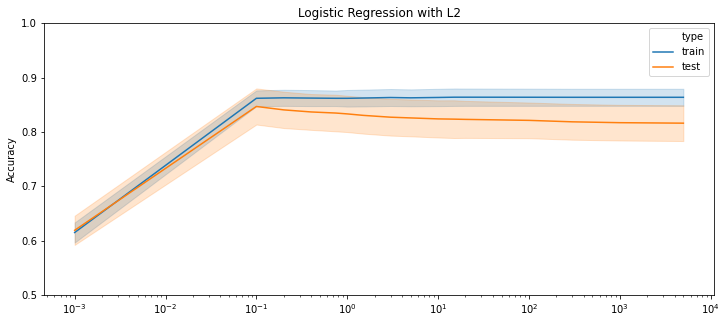

Highest Test Set Achieved = 0.846827
Best C Parameter = 0.100000


In [8]:
classification_plotter(lr_res2, xscale='log', C=C, x='C', ylabel='Accuracy', 
                       ylim=[0.5, 1], title='Logistic Regression with L2', 
                       figsize=(12,5))

max_test = np.amax(lr_res2.loc[lr_res2['type']=='test'].groupby('C')\
                   .mean()['value'])
max_C = C[np.argmax(lr_res2.loc[lr_res2['type']=='test'].groupby('C').mean())]
mean_coef_matrix = lr_res2_coefs.loc[lr_res2_coefs[0]==max_C][1].mean()
best_predictor = np.argmax(np.mean(np.abs(mean_coef_matrix), axis=0))

print("Highest Test Set Achieved = %f" % max_test)
print("Best C Parameter = %f" % max_C)

summary_list.append({'method': 'Logistic Regression - L2', 
                     'accuracy': f"{max_test*100:.2f}%", 
                     'optimal': f"C={max_C}",
                     'best_predictor': f"{features.columns[best_predictor]}"})

#### Logistic Regression with L1

In [9]:
C=[1e-3,0.1, 0.2,0.4, 0.75, 1, 1.5, 3, 5, 10, 15,  20, 100, 300, 1000, 5000]

lr_res1, lr_res1_coefs = logistic_regression(features, target, 
                                             max_iter=1e5, C=C, 
                                             penalty='l1', solver='saga', 
                                             scaler=RobustScaler())


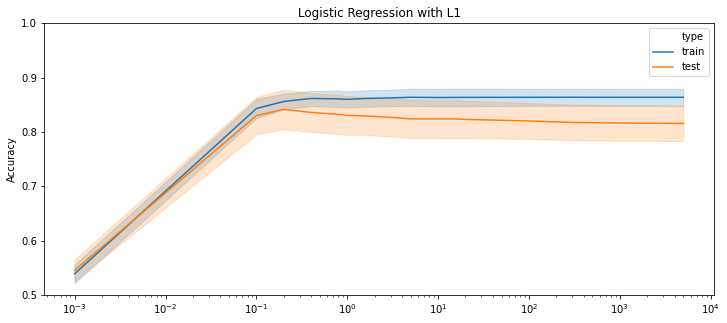

Highest Test Set Achieved = 0.841444
Best C Parameter = 0.200000


In [12]:
classification_plotter(lr_res1, xscale='log', C=C, x='C', ylabel='Accuracy', 
                       ylim=[0.5, 1], title='Logistic Regression with L1', 
                       figsize=(12,5))

max_test = np.amax(lr_res1.loc[lr_res1['type']=='test'].groupby('C')\
                   .mean()['value'])
max_C = C[np.argmax(lr_res1.loc[lr_res1['type']=='test'].groupby('C').mean())]
mean_coef_matrix = lr_res1_coefs.loc[lr_res1_coefs[0]==max_C][1].mean()
best_predictor = np.argmax(np.mean(np.abs(mean_coef_matrix), axis=0))

print("Highest Test Set Achieved = %f" % max_test)
print("Best C Parameter = %f" % max_C)

summary_list.append({'method': 'Logistic Regression - L1', 
                     'accuracy': f"{max_test*100:.2f}%", 
                     'optimal': f"C={max_C}",
                     'best_predictor': f"{features.columns[best_predictor]}"})

#### Linear SVM with L2

In [13]:
C=[1e-3,0.1, 0.2,0.4, 0.75, 1, 1.5, 3, 5, 10, 15,  20, 100, 300, 1000, 5000]
ls_res2, ls_res2_coefs = linear_svm(features, target, C=C, 
                                    max_iter=1e5, scaler=RobustScaler())

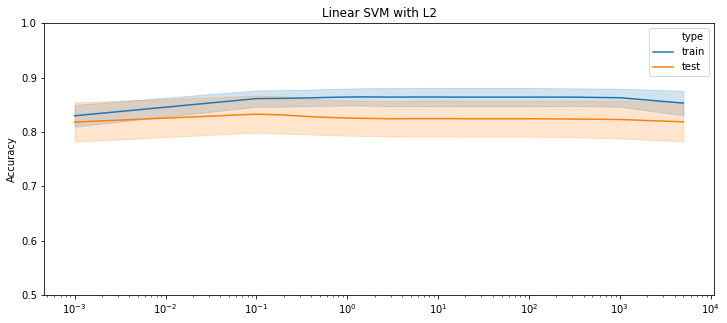

Highest Test Set Achieved = 0.832698
Best C Parameter = 0.100000


In [14]:
classification_plotter(ls_res2, xscale='log', C=C, x='C', ylabel='Accuracy', 
                       ylim=[0.5, 1], title='Linear SVM with L2', 
                       figsize=(12,5))

max_test = np.amax(ls_res2.loc[ls_res2['type']=='test'].groupby('C')\
                   .mean()['value'])
max_C = C[np.argmax(ls_res2.loc[ls_res2['type']=='test'].groupby('C').mean())]
mean_coef_matrix = ls_res2_coefs.loc[ls_res2_coefs[0]==max_C][1].mean()
best_predictor = np.argmax(np.mean(np.abs(mean_coef_matrix), axis=0))

print("Highest Test Set Achieved = %f" % max_test)
print("Best C Parameter = %f" % max_C)

summary_list.append({'method': 'Linear SVM - L2', 
                     'accuracy': f"{max_test*100:.2f}%", 
                     'optimal': f"C={max_C}", 
                     'best_predictor': f"{features.columns[best_predictor]}"})

#### Linear SVM with L1

In [15]:
C=[1e-3,0.1, 0.2,0.4, 0.75, 1, 1.5, 3, 5, 10, 15,  20, 100, 300, 1000, 5000]
ls_res1, ls_res1_coefs = linear_svm(features, target, C=C, max_iter=1e5, 
                                    penalty='l1', dual=False, 
                                    scaler=RobustScaler())

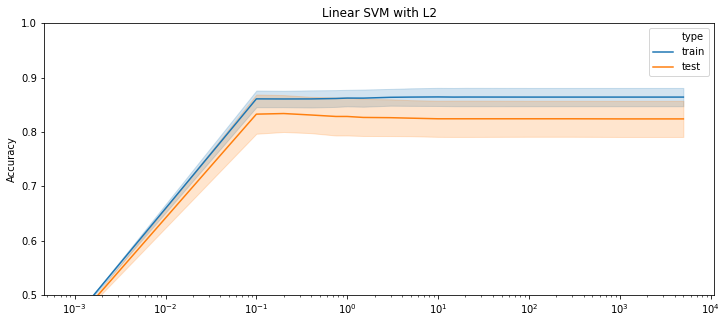

Highest Test Set Achieved = 0.833819
Best C Parameter = 0.200000


In [16]:
classification_plotter(ls_res1, xscale='log', C=C, x='C', ylabel='Accuracy', 
                       ylim=[0.5, 1], title='Linear SVM with L2', 
                       figsize=(12,5))

max_test = np.amax(ls_res1.loc[ls_res1['type']=='test'].groupby('C')\
                   .mean()['value'])
max_C = C[np.argmax(ls_res1.loc[ls_res1['type']=='test'].groupby('C').mean())]
mean_coef_matrix = ls_res1_coefs.loc[ls_res1_coefs[0]==max_C][1].mean()
best_predictor = np.argmax(np.mean(np.abs(mean_coef_matrix), axis=0))

print("Highest Test Set Achieved = %f" % max_test)
print("Best C Parameter = %f" % max_C)

summary_list.append({'method': 'Linear SVM - L1', 
                     'accuracy': f"{max_test*100:.2f}%", 
                     'optimal': f"C={max_C}",
                     'best_predictor': f"{features.columns[best_predictor]}"
                    })

In [21]:
summary(summary_list)

## SUMMARY OF RESULTS
| **Method** | **Accuracy** | **Optimal Parameters** | **Best Predictor** |
| :---: | :---: | :---: | :---: |
|Logistic Regression - L2 | 84.68% | C=0.1 | cp_0
|Logistic Regression - L1 | 84.14% | C=0.2 | cp_0
|Logistic Regression - L1 | 84.14% | C=0.2 | cp_0
|Linear SVM - L2 | 83.27% | C=0.1 | sex
|Linear SVM - L1 | 83.38% | C=0.2 | cp_0


# IV. Conclusion

As seen in the summary of results, our model was able to reach an accuracy of <b>84.68%</b> using Logistic Regression with L2 regularization. Apart from this, we also applied a scaler to the features to make them comparable and improve the model's accuracy.

In [18]:
from IPython.display import HTML
HTML('<center><iframe width="800" height="600" src="https://www.youtube-nocookie.com/embed/1MAgBWStblo?controls=0" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe></center>')